In [4]:
with open('names.txt', 'r') as f:
    names = f.read().split('\n')

names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(names)

32033

In [25]:
# Build vocabulary
vocab = []
for name in names:
    vocab += name
vocab = sorted(set(vocab))

# Build mapping from letter to integer id and for id to letter
itos = { i+1:l for i, l in enumerate(vocab)}
# Additional `point` at index 0
itos[0] = '.'
stoi = { l:i for i, l in itos.items()}

In [221]:
# Build a dataset
import torch


def build_dataset(words):
    # Context lenght -> How many characters we take to predict the next
    block_size = 3
    
    # Inputs
    X = []
    # Targets
    Y = []
    
    # For each name
    for word in words:
        # The start is an empty new context (which contains our designed dot special character)
        context = [0] * block_size
        # For each character in the name (adding dot as a stopping token)
        for ch in word + '.':
            # We add the current context and as an input to the dataset
            X.append(context)
            # Get the index of the current character and add it as a target for a potential
            # generated new character that could follow this context
            idx_ch = stoi[ch]
            Y.append(idx_ch)
            # Slide the context window and add the new character to it
            context = context[1:] + [idx_ch]

    X = torch.Tensor(X).long()
    Y = torch.Tensor(Y).long()
    return (X, Y)


import random
random.seed(0x1337_b00b)
# Shuffle names in place
random.shuffle(names)
# Training set and dev/validation set last index
train_set_idx = int(0.8 * len(names))
validation_idx = int(0.9 * len(names))

Xtrain, Ytrain = build_dataset(names[:train_set_idx])
Xvalid, Yvalid = build_dataset(names[train_set_idx:validation_idx])
Xtest, Ytest = build_dataset(names[validation_idx:])

# View demo of dataset
def dataset_demo():
    for i, p in zip(X[:20], Y[:20]):
        print([itos[c] for c in i], "-->", itos[p])


In [222]:
Ytrain.shape, Yvalid.shape, Ytest.shape

(torch.Size([182452]), torch.Size([22787]), torch.Size([22907]))

In [148]:
# Create the embedding
# Each element gets a 2 value embedding
C = torch.randn((27, 2))
# Because of pytorch, we can index into the C table using a list or a list of lists
# X in this case
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [64]:
# Initializing the model parameters
W1 = torch.randn((3 * 2, 100))
b1 = torch.randn(100)

In [72]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [73]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
# Output of the final layer
logits = h @ W2 + b2 # log-counts
logits.shape

torch.Size([32, 27])

In [74]:
# Nomarlisation

In [90]:
# Normalisr the rows to convert logits into probabilities
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])


torch.Size([32, 27])

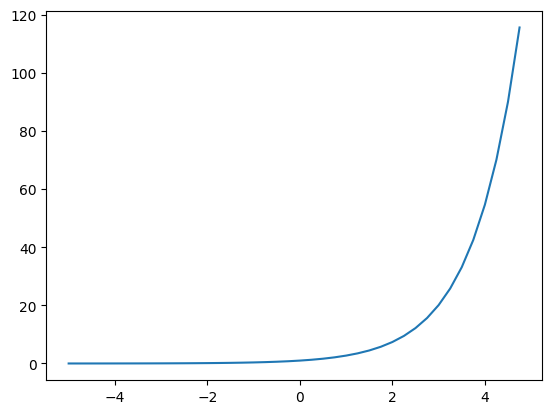

In [87]:
import numpy as np
a = np.arange(-5., 5., 0.25)
import matplotlib.pyplot as plt
import math
plt.plot(a, [math.exp(i) for i in a])


In [91]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0],
       dtype=torch.int32)

In [102]:
# Log will output from value from 0 (max, when all probs/predictions are 1.0)
# all the way to -inf
# Mean is used to gather them up
# minus is used to make the loss positive
loss = -prob[torch.arange(32), Y].log().mean()

tensor(inf)

In [ ]:
def manual_loss():
    # Normalise the rows to convert logits into probabilities
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    # Compute the loss over all the 32 inputs
    loss_manual = -probs[torch.arange(32), Y].log().mean()
    print(loss_manual)

In [239]:
# Parameters setup
from torch.nn import functional as F

g = torch.Generator().manual_seed(0x1337_b00b)
# Create the embedding
C = torch.randn((27, 2), generator=g)

# Initializing the model parameters
# First layer
W1 = torch.randn((3 * 2, 300), generator=g)
b1 = torch.randn(300, generator=g)
# Second layer
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [240]:
sum(p.nelement() for p in parameters)

10281

In [241]:
# Tuning the learning rate
lr_exponents = torch.linspace(-3, 0, 1000)
lrs = 10**lr_exponents

In [260]:
lrs_used = []
losses = []
steps = []

for idx in range(30000):
    # Minibatch construction
    # Sample indexes from X (minibatch of 32 examples)
    idxs = torch.randint(0, Xtrain.shape[0], (32,))
    
    # Forward pass, only with the minibatch
    emb = C[Xtrain[idxs]]
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
    logits = h @ W2 + b2 # log-counts
    # Compute the loss
    loss = F.cross_entropy(logits, Ytrain[idxs])
    #print(loss.item())
    # Reset the gradients
    for p in parameters:
        p.grad = None
    # Compute the backward pass
    loss.backward()
    # Gradually increase the learning rate in each step
    # lr = lrs[idx]
    lr = 0.01
    # Update / nudge the value in the direction of the gradietn
    for p in parameters:
        p.data += -lr * p.grad

    # Track progress
    # lrs_used.append(lr_exponents[idx])
    steps.append(idx)
    losses.append(loss.item())

loss

tensor(2.0741, grad_fn=<NllLossBackward0>)

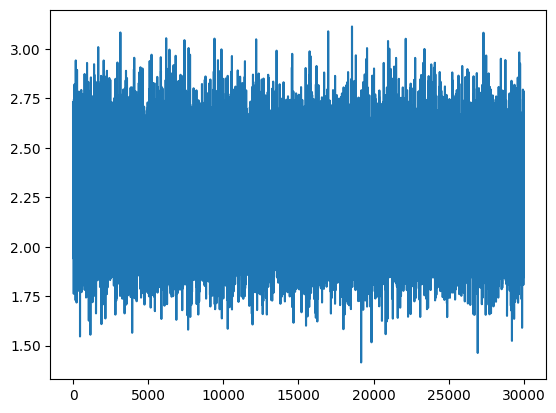

In [261]:
plt.plot(steps, losses)

In [262]:
# Loss over the entire training set
emb = C[Xtrain]
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2 # log-counts
# Compute the loss
loss = F.cross_entropy(logits, Ytrain)
loss

tensor(2.2355, grad_fn=<NllLossBackward0>)

In [263]:
# Loss over the entire training set
emb = C[Xvalid]
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2 # log-counts
# Compute the loss
loss = F.cross_entropy(logits, Yvalid)
loss

tensor(2.2468, grad_fn=<NllLossBackward0>)

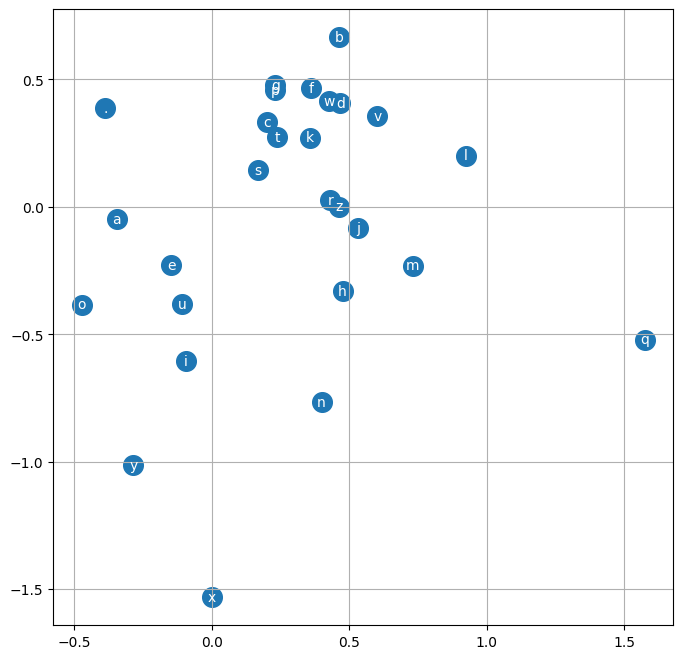

In [266]:
# Explore the embedding space after training
plt.figure(figsize = (8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')